In [92]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import metrics
from skopt import dump, load
from skopt.plots import plot_convergence
from scipy.stats import reciprocal
import skopt
from skopt import gp_minimize
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn import metrics
import datetime
import re
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Reusable Constants

In [2]:
CALLBACKS = [keras.callbacks.EarlyStopping(patience=5, monitor='val_mean_squared_error', restore_best_weights=True)]

# Load Data from Sources

In [3]:
df = pd.read_excel('mlb_team_batting_wp.xlsx')

In [4]:
df.columns

Index(['Season', 'Team', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI',
       'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'SB', 'CS', 'AVG', 'W', 'L',
       'win_per'],
      dtype='object')

In [5]:
df.shape

(1468, 23)

# Data Pre-Processing

The target for this model will be predicting winning percentage using offensive statistics provided by pybaseball. The following pre-processings must be done:
- Remove wins and loss column, this is part of the prediction
- Remove the average column, batting average is an aggregate statistic and I want to focus on continous values
- Removing hits (H) as it is the sum of the different types of hits
- Remove runs category, I want to focus on other statistics as Runs is known to be an indicator of wins
- Remove RBI for the same reason

In [8]:
mlb_df = df.drop(labels=['Season', 'Team', 'H', 'R', 'RBI', 'AVG', 'W', 'L', 'AB'], axis=1)
mlb_df.columns

Index(['PA', '1B', '2B', '3B', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH',
       'SB', 'CS', 'win_per'],
      dtype='object')

In [9]:
mlb_df.shape

(1468, 14)

### Normalizing Input Vector

Since the values range widely, apply a scaler function to the input vector. Output vector can remain the same as it will always be a value between 0 and 1

In [10]:
x = mlb_df[['PA', '1B', '2B', '3B', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'SB', 'CS']].to_numpy()
y = mlb_df[['win_per']].to_numpy()

In [11]:
x_scaler = MinMaxScaler().fit(x)
x_scaled = x_scaler.transform(x)

In [12]:
# Split last 25% of data for test data
split_val = int(x.shape[0] * .75)
x_train_full, x_test = x_scaled[:split_val], x_scaled[split_val:]
y_train_full, y_test = y[:split_val], y[split_val:]

# Simple Model Build

In [114]:
def build_simple_model():
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=(13,), name='input'))
    
    model.add(keras.layers.Dense(units=8, activation='relu', name='hidden'))
    
    model.add(keras.layers.Dense(units=1, activation='sigmoid', name='output'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer='sgd',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
    return model

In [115]:
sm_model = build_simple_model()
sm_model.fit(x_train_full, y_train_full, epochs=30, verbose=0)
# sm_model.save('models/simple_mlbwp')

In [116]:
predicted = sm_model.predict(x_test)
mean_squared_error(predicted, y_test)

0.005739080729872591

# Impact of Initialization

Look for the differences in the simple model using different starting values for synaptic weights.

In [27]:
def build_model_init_test(weights, bias):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(13,), name='input'))
    
    model.add(keras.layers.Dense(
        units=8, 
        activation='relu',
        kernel_initializer=weights,
        bias_initializer=bias,
        name='hidden'))
    
    model.add(keras.layers.Dense(units=1, activation='sigmoid', name='output'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer='sgd',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
    return model

In [50]:
# Testing different kernal and bias initializers
# Bias and kernal weights will be tested together
# Test for speed, result, and epoch count for each
def run_init_test():
    initializers = ['zeros', 'ones', 'random_normal', 'random_uniform', 'truncated_normal', 'glorot_normal']
    init_test_results = []
    for i in initializers:
        # Perform each test 5 times to get an average of the testing results
        test_mse = []
        test_time = []
        test_epoch = []
        for j in range(10):
            test_model = build_model_init_test(i, i)
            start = time.time()
            test_history = test_model.fit(x_train_full, y_train_full, validation_split=.2, epochs=30, callbacks=CALLBACKS, verbose=0)
            end = time.time()
            test_mse.append(mean_squared_error(y_test, test_model.predict(x_test)))
            test_time.append(end - start)
            test_epoch.append(len(test_history.history['loss']))
        avg_test_mse, avg_test_time, avg_test_epoch = np.mean(test_mse), np.mean(test_time), np.mean(test_epoch)
        init_test_results.append(([ i for x in range(10) ], test_mse, test_time, test_epoch))
        print(f'{i} :: {avg_test_mse} {avg_test_time} {avg_test_epoch}')
    return init_test_results

In [51]:
init_test_results = run_init_test()

zeros :: 0.00578389838825659 1.0610269784927369 6.0
ones :: 0.0800828511420871 1.5185487985610961 12.7
random_normal :: 0.0057635681200177615 2.578262138366699 27.6
random_uniform :: 0.005750116628861741 2.676836133003235 30.0
truncated_normal :: 0.005711211723181963 2.371379041671753 28.0
glorot_normal :: 0.006775198705471455 2.4475701093673705 28.3


### Build graphs for this section

In [95]:
temp = [ list(zip(x[0], x[1], x[2], x[3])) for x in init_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['initializer', 'mse', 'time', 'epochs'])

In [90]:
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.5)
# sns.boxplot(x='initializer', y='mse', data=init_test_df).figure.savefig('mlbwp_init_mse.png')

In [92]:
#sns.boxplot(x='initializer', y='time', data=init_test_df).figure.savefig('mlbwp_init_time.png')

In [94]:
#sns.boxplot(x='initializer', y='epochs', data=init_test_df).figure.savefig('mlbwp_init_epochs.png')

# Impact of Learning Algorithm

Impact of learning algorithm on training time, MSE, and complexity.

In [96]:
def build_model_learn_test(opt):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(13,), name='input'))
    
    model.add(keras.layers.Dense(
        units=8, 
        activation='relu',
        name='hidden'))
    
    model.add(keras.layers.Dense(units=1, activation='sigmoid', name='output'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer=opt,
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
    return model

In [110]:
def run_learn_test():
    opts = ['sgd', 'adam', 'rmsprop']
    learn_test_results = []
    for i in opts:
        # Perform each test 5 times to get an average of the testing results
        test_mse = []
        test_time = []
        test_epoch = []
        for j in range(10):
            test_model = build_model_learn_test(i)
            start = time.time()
            test_history = test_model.fit(x_train_full, y_train_full, validation_split=.2, epochs=30, callbacks=CALLBACKS, verbose=0)
            end = time.time()
            test_mse.append(mean_squared_error(y_test, test_model.predict(x_test)))
            test_time.append(end - start)
            test_epoch.append(len(test_history.history['loss']))
        avg_test_mse, avg_test_time, avg_test_epoch = np.mean(test_mse), np.mean(test_time), np.mean(test_epoch)
        learn_test_results.append(([ i for x in range(10) ], test_mse, test_time, test_epoch))
        print(f'{i} :: {avg_test_mse} {avg_test_time} {avg_test_epoch}')
    return learn_test_results

In [111]:
learn_test_results = run_learn_test()

sgd :: 0.006789618754675077 2.497562885284424 25.9
adam :: 0.005015887293620576 2.784060025215149 30.0
rmsprop :: 0.005260801052864236 2.932689332962036 28.1


# Build graphs for this section

In [112]:
temp = [ list(zip(x[0], x[1], x[2], x[3])) for x in learn_test_results ]
learn_test_data = []
for i in temp:
    for j in i:
        learn_test_data.append(j)
learn_test_df = pd.DataFrame(data=learn_test_data, columns=['learn_alg', 'mse', 'time', 'epochs'])

In [117]:
sns.set(rc={'figure.figsize':(8,8)}, font_scale=1.5)
# sns.boxplot(x='learn_alg', y='mse', data=learn_test_df).figure.savefig('mlbwp_learn_mse.png')

In [121]:
# sns.boxplot(x='learn_alg', y='time', data=learn_test_df).figure.savefig('mlbwp_learn_time.png')

In [123]:
# sns.boxplot(x='learn_alg', y='epochs', data=learn_test_df).figure.savefig('mlbwp_learn_epochs.png')

# Hyper-Parameter Tuning using SKOPT

Hyper-Parameter Tuning for the following values:
- Number of layers
- Number of neurons in each layer
- Learning algorithm (?)
- Learning rate
- Dropout rate
- L1, L2, L1_L2 regularization

In [128]:
def build_model(n_units=[10], n_layers=1, activation='relu', output_activation=None, learning_rate=1e-3, dropout_rate=0, optimizer='adam'):
    model = keras.models.Sequential()
    
    # input layer
    model.add(keras.layers.InputLayer(input_shape=(13,), name='input_layer'))
    
    # hidden layers
    for i in range(n_layers):
        model.add(keras.layers.Dense(
            units=n_units[i], 
            activation=activation, 
            name=f'hidden_layer_{i}')
        )
    # model.add(keras.layers.Dropout(rate=dropout_rate))
        
    # output layer
    model.add(keras.layers.Dense(1, activation=output_activation, name='output_layer'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        learning_rate=learning_rate,
        metrics=['mean_squared_error']
    )
    
    return model

In [129]:
SPACE_ONE_LAYER = [
    skopt.space.Integer(2, 12, name='n_units_one'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Categorical(['relu', 'sigmoid', 'tanh', 'selu'], name='activation'),
    skopt.space.Categorical(['sigmoid', None], name='output_activation'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate'),
    skopt.space.Categorical(['adam', 'sgd'], name='optimizer')
]
SPACE_TWO_LAYER = [
    skopt.space.Integer(7, 12, name='n_units_one'),
    skopt.space.Integer(2, 6, name='n_units_two'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Categorical(['relu', 'sigmoid', 'tanh', 'selu'], name='activation'),
    skopt.space.Categorical(['sigmoid', None], name='output_activation'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate'),
    skopt.space.Categorical(['adam', 'sgd'], name='optimizer')
]
SPACE_THREE_LAYER = [
    skopt.space.Integer(9, 12, name='n_units_one'),
    skopt.space.Integer(5, 8, name='n_units_two'),
    skopt.space.Integer(2, 4, name='n_units_three'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Categorical(['relu', 'sigmoid', 'tanh', 'selu'], name='activation'),
    skopt.space.Categorical(['sigmoid', None], name='output_activation'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate'),
    skopt.space.Categorical(['adam', 'sgd'], name='optimizer')
]

### One Hidden Layer

In [130]:
@skopt.utils.use_named_args(SPACE_ONE_LAYER)
def objective_one_layer(**params):
    print('-----------------------------------------------------------------------------------')
    print('Testing Parameters: ')
    print('Layer One Units: {} '.format(params['n_units_one']))
    print('Learning Rate: {}'.format(params['learning_rate']))
    print('Activation: {}'.format(params['activation']))
    print('Output Activation: {}'.format(params['output_activation']))
    print('Dropout rate: {}'.format(params['dropout_rate']))
    print('Optimizer: {}'.format(params['optimizer']))
    
    valid_mse_scores = []
    cv = KFold(10)
    for train_idx, test_idx in cv.split(x_train_full):
        # Get train valid splits
        x_train, x_valid = x_train_full[train_idx], x_train_full[test_idx]
        y_train, y_valid = y_train_full[train_idx], y_train_full[test_idx]
        
        # fit model
        model = build_model(
            n_units=[params['n_units_one']],
            n_layers=1,
            learning_rate=params['learning_rate'],
            activation=params['activation'],
            output_activation=params['output_activation'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer']
        )
        model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), callbacks=CALLBACKS, verbose=0)
        trial_score = model.evaluate(x_valid, y_valid, verbose=0)[1]
        print(f'Validation MSE: {trial_score}')
        valid_mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(valid_mse_scores)}')
    return np.mean(valid_mse_scores)

In [131]:
one_opt_results = gp_minimize(objective_one_layer, SPACE_ONE_LAYER, n_calls=20, random_state=0)

-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 8 
Learning Rate: 0.0074249082318150125
Activation: tanh
Output Activation: None
Dropout rate: 0.4221328742905088
Optimizer: adam
Validation MSE: 0.003442114219069481
Validation MSE: 0.010151306167244911
Validation MSE: 0.008787104859948158
Validation MSE: 0.002197104040533304
Validation MSE: 0.006877346429973841
Validation MSE: 0.0047784061171114445
Validation MSE: 0.011257587000727654
Validation MSE: 0.0038920221850275993
Validation MSE: 0.003547850763425231
Validation MSE: 0.007345340680330992
Avg Validation MSE: 0.006227618083357811
-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 5 
Learning Rate: 0.027321603619774242
Activation: selu
Output Activation: sigmoid
Dropout rate: 0.028356488658721597
Optimizer: adam
Validation MSE: 0.01599281281232834
Validation MSE: 0.004212862811982632
Valida

In [135]:
dump(one_opt_results, 'tuning/one_opt_results.pkl')

In [136]:
one_opt_loaded = load('tuning/one_opt_results.pkl')

In [137]:
print(f"""
    Best Avg. Val Acc: {one_opt_loaded.fun:.4f}
    Best Parameters:
    - Dense Layer 1: {one_opt_loaded.x[0]}
    - Dropout Rate: {one_opt_loaded.x[1]}
    - Activation: {one_opt_loaded.x[2]}
    - Out. Act.: {one_opt_loaded.x[3]}
    - Learning Rate: {one_opt_loaded.x[4]}
    - Optimizer: {one_opt_loaded.x[5]}
    
""")


    Best Avg. Val Acc: 0.0031
    Best Parameters:
    - Dense Layer 1: 11
    - Dropout Rate: 0.4041340464695242
    - Activation: tanh
    - Out. Act.: sigmoid
    - Learning Rate: 0.0001
    - Optimizer: adam
    



### Two Hidden Layers

In [67]:
@skopt.utils.use_named_args(SPACE_TWO_LAYER)
def objective_two_layer(**params):
    print('-----------------------------------------------------------------------------------')
    print('Testing Parameters: ')
    print('Layer One Units: {}'.format(params['n_units_one']))
    print('Layer Two Units: {}'.format(params['n_units_two']))
    print('Learning Rate: {}'.format(params['learning_rate']))
    print('Activation: {}'.format(params['activation']))
    print('Output Activation: {}'.format(params['output_activation']))
    print('Dropout rate: {}'.format(params['dropout_rate']))
    print('Optimizer: {}'.format(params['optimizer']))
    
    valid_mse_scores = []
    cv = KFold(10)
    for train_idx, test_idx in cv.split(x_train_full):
        # Get train valid splits
        x_train, x_valid = x_train_full[train_idx], x_train_full[test_idx]
        y_train, y_valid = y_train_full[train_idx], y_train_full[test_idx]
        
        # fit model
        model = build_model(
            n_units=[params['n_units_one'], params['n_units_two']],
            n_layers=2,
            learning_rate=params['learning_rate'],
            activation=params['activation'],
            output_activation=params['output_activation'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer']
        )
        model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), callbacks=CALLBACKS, verbose=0)
        trial_score = model.evaluate(x_valid, y_valid, verbose=0)[1]
        print(f'Validation MSE: {trial_score}')
        valid_mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(valid_mse_scores)}')
    return np.mean(valid_mse_scores)

In [68]:
two_opt_results = gp_minimize(objective_two_layer, SPACE_TWO_LAYER, n_calls=20, random_state=0)

-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 10
Layer Two Units: 5
Learning Rate: 0.0014228041454890754
Activation: tanh
Output Activation: None
Dropout rate: 0.4289728088113785
Optimizer: adam
Validation MSE: 0.005845449864864349
Validation MSE: 0.002855911385267973
Validation MSE: 0.0050294664688408375
Validation MSE: 0.0026043024845421314
Validation MSE: 0.003148365532979369
Validation MSE: 0.0032148081809282303
Validation MSE: 0.0030757631175220013
Validation MSE: 0.0032674053218215704
Validation MSE: 0.0050209639593958855
Validation MSE: 0.005044758319854736
Avg Validation MSE: 0.00391071941703558
-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 7
Layer Two Units: 3
Learning Rate: 0.0015078369731868298
Activation: sigmoid
Output Activation: sigmoid
Dropout rate: 0.238832558660675
Optimizer: sgd
Validation MSE: 0.005527784116566181
Va

In [69]:
dump(two_opt_results, 'tuning/two_opt_results.pkl')

In [70]:
two_opt_loaded = load('tuning/two_opt_results.pkl')

In [71]:
print(f"""
    Best Avg. Val Acc: {two_opt_loaded.fun:.4f}
    Best Parameters:
    - Dense Layer 1: {two_opt_loaded.x[0]}
    - Dense Layer 2: {two_opt_loaded.x[1]}
    - Dropout Rate: {two_opt_loaded.x[2]}
    - Activation: {two_opt_loaded.x[3]}
    - Out. Act.: {two_opt_loaded.x[4]}
    - Learning Rate: {two_opt_loaded.x[5]}
    - Optimizer: {two_opt_loaded.x[6]}
    
""")


    Best Avg. Val Acc: 0.0032
    Best Parameters:
    - Dense Layer 1: 9
    - Dense Layer 2: 5
    - Dropout Rate: 0.184120769920274
    - Activation: tanh
    - Out. Act.: sigmoid
    - Learning Rate: 0.040762590410962536
    - Optimizer: adam
    



### Three Hidden Layers

In [72]:
@skopt.utils.use_named_args(SPACE_THREE_LAYER)
def objective_three_layer(**params):
    print('-----------------------------------------------------------------------------------')
    print('Testing Parameters: ')
    print('Layer One Units: {}'.format(params['n_units_one']))
    print('Layer Two Units: {}'.format(params['n_units_two']))
    print('Layer Three Units: {}'.format(params['n_units_three']))
    print('Learning Rate: {}'.format(params['learning_rate']))
    print('Activation: {}'.format(params['activation']))
    print('Output Activation: {}'.format(params['output_activation']))
    print('Dropout rate: {}'.format(params['dropout_rate']))
    print('Optimizer: {}'.format(params['optimizer']))
    
    valid_mse_scores = []
    cv = KFold(10)
    for train_idx, test_idx in cv.split(x_train_full):
        # Get train valid splits
        x_train, x_valid = x_train_full[train_idx], x_train_full[test_idx]
        y_train, y_valid = y_train_full[train_idx], y_train_full[test_idx]
        
        # fit model
        model = build_model(
            n_units=[params['n_units_one'], params['n_units_two'], params['n_units_three']],
            n_layers=3,
            learning_rate=params['learning_rate'],
            activation=params['activation'],
            output_activation=params['output_activation'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer']
        )
        model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), callbacks=CALLBACKS, verbose=0)
        trial_score = model.evaluate(x_valid, y_valid, verbose=0)[1]
        print(f'Validation MSE: {trial_score}')
        valid_mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(valid_mse_scores)}')
    return np.mean(valid_mse_scores)

In [73]:
three_opt_results = gp_minimize(objective_three_layer, SPACE_THREE_LAYER, n_calls=20, random_state=0)

-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 11
Layer Two Units: 8
Layer Three Units: 4
Learning Rate: 0.0007809150983452719
Activation: sigmoid
Output Activation: sigmoid
Dropout rate: 0.4236258693920628
Optimizer: adam
Validation MSE: 0.005537304561585188
Validation MSE: 0.005303580779582262
Validation MSE: 0.005333334673196077
Validation MSE: 0.004193591419607401
Validation MSE: 0.003820290556177497
Validation MSE: 0.003951543476432562
Validation MSE: 0.0042624399065971375
Validation MSE: 0.0058128624223172665
Validation MSE: 0.0061601134948432446
Validation MSE: 0.003724690992385149
Avg Validation MSE: 0.004809975158423185
-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 10
Layer Two Units: 6
Layer Three Units: 4
Learning Rate: 0.001028462547983764
Activation: selu
Output Activation: None
Dropout rate: 0.23998858618752872
Optimizer: s

In [74]:
dump(three_opt_results, 'tuning/three_opt_results.pkl')

In [75]:
three_opt_loaded = load('tuning/three_opt_results.pkl')

In [76]:
print(f"""
    Best Avg. Val Acc: {three_opt_loaded.fun:.4f}
    Best Parameters:
    - Dense Layer 1: {three_opt_loaded.x[0]}
    - Dense Layer 2: {three_opt_loaded.x[1]}
    - Dense Layer 3: {three_opt_loaded.x[2]}
    - Dropout Rate: {three_opt_loaded.x[3]}
    - Activation: {three_opt_loaded.x[4]}
    - Out. Act.: {three_opt_loaded.x[5]}
    - Learning Rate: {three_opt_loaded.x[6]}
    - Optimizer: {three_opt_loaded.x[7]}
    
""")


    Best Avg. Val Acc: 0.0031
    Best Parameters:
    - Dense Layer 1: 10
    - Dense Layer 2: 5
    - Dense Layer 3: 3
    - Dropout Rate: 0.0748374335918416
    - Activation: selu
    - Out. Act.: sigmoid
    - Learning Rate: 0.051026458440329624
    - Optimizer: adam
    



### Evaluating Hyper-Parameter Tuning

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

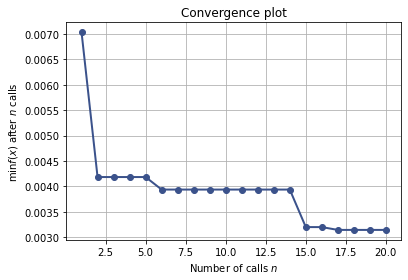

In [77]:
plot_convergence(one_opt_loaded)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

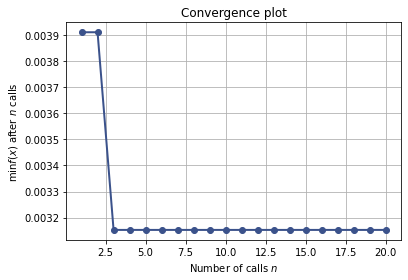

In [78]:
plot_convergence(two_opt_loaded)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

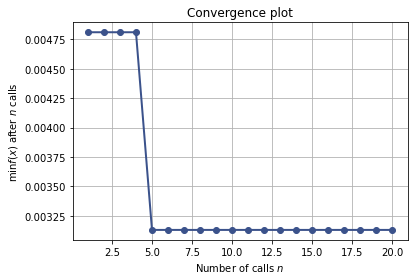

In [79]:
plot_convergence(three_opt_loaded)

# Model Performance & Evaluation

Evaluate the $R^2$, MSE, and other metrics for the final tuned model

### Build Model with Best Parameters from Tuning

In [83]:
one_opt_loaded.x

[12, 0.4263143088704164, 'selu', 'sigmoid', 0.00015736515311680008, 'adam']

In [85]:
tuned_model = build_model(
    n_units=[12],
    n_layers=1,
    dropout_rate=.4263143088704164,
    activation='selu',
    output_activation='sigmoid',
    learning_rate=.00015736515311680008,
    optimizer='adam'
)

In [86]:
tuned_model.summary()

Model: "sequential_1351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 12)                168       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 13        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [89]:
tuned_model.fit(x_train_full, y_train_full, epochs=30, validation_split=.1, callbacks=CALLBACKS, verbose=1)

Train on 990 samples, validate on 111 samples
Epoch 1/30
990/990 [==============================] - 1s 826us/sample - loss: 0.0595 - mean_squared_error: 0.0595 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 2/30
990/990 [==============================] - 0s 95us/sample - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/30
990/990 [==============================] - 0s 94us/sample - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/30
990/990 [==============================] - 0s 98us/sample - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/30
990/990 [==============================] - 0s 117us/sample - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/30
990/990 [==============================] - 0s 113us/sample - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0

In [90]:
predictions = tuned_model.predict(x_test)

In [91]:
mean_squared_error(y_test, predictions)

0.004855598843200306

In [109]:
r2_score(y_test, predictions)

0.16042788740454816

In [99]:
y_test_g = [ x[0] for x in y_test ] 
predictions_g = np.array([ x[0] for x in predictions ])

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Actual vs Predicted')]

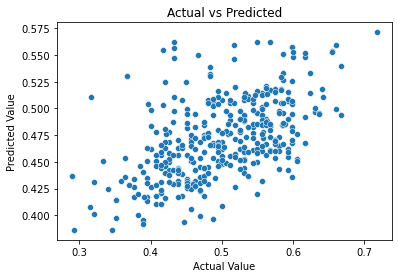

In [112]:
ax = sns.scatterplot(x=y_test_g, y=predictions_g)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Actual vs Predicted')

In [101]:
errors = y_test_g - predictions_g

[Text(0.5, 0, 'Error'), Text(0.5, 1.0, 'Binned Error Counts')]

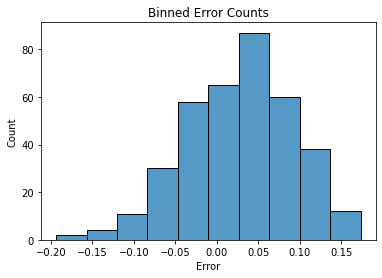

In [105]:
ax = sns.histplot(data=errors, bins=10)
ax.set(xlabel='Error', title='Binned Error Counts')